## Cat Dog Dataset

The training archive contains 25,000 images of dogs and cats. Train your algorithm on these files and predict the labels for test1.zip (1 = dog, 0 = cat).

You can obtain the dataset from https://www.kaggle.com/c/dogs-vs-cats/data

This case study is adopted from https://www.kaggle.com/uysimty/keras-cnn-dog-or-cat-classification

### 1. Import Library

In [1]:
import numpy as np
import pandas as pd 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import random
from _data_new import organise_images_in_folders
import os, logging, glob
from _dataset import dataset
from _cnn import Cnn
from _logging import set_logging
from _utility import get_perc, get_dictionaries_from_list
from _pckle import save_pickle_object

set_logging(logging)
data_folder = "cats_dogs_small"
classes = ["cat", "dog"]
dict_classes, dict_classes_rev = get_dictionaries_from_list(classes)
organise_images_flag = False
if organise_images_flag:
    organise_images_in_folders(data_folder, classes)

#class of gpu
class gpu:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# class of hyperparameters
class hyper:
    lr = 0.001
    batch_size = 100
    epochs = 20
    


### 2. Define Constants

In [2]:
FAST_RUN = True #False
IMAGE_WIDTH=256
IMAGE_HEIGHT=256
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

### 3. Prepare Traning Data

In [3]:
def get_data(data_folder, type, dict_classes):
    file_path = os.path.join(data_folder, "data", type, "*\\*")
    list = glob.glob(file_path)
    num_dogs = 0
    for item in list:
        _key = Path(item).parts[3]
        num_dogs += dict_classes[_key]
    X_list = random.sample(list, len(list))
    return X_list, num_dogs

        

In [4]:
X_train, train_num_dogs = get_data(data_folder, "train", dict_classes)
X_val, val_num_dogs = get_data(data_folder, "val", dict_classes)
X_test, test_num_dogs = get_data(data_folder, "test", dict_classes)
train_data = dataset(X_train, dict_classes, IMAGE_SIZE, logging)
val_data = dataset(X_val, dict_classes, IMAGE_SIZE, logging)
test_data = dataset(X_test, dict_classes, IMAGE_SIZE, logging)
train_loader = DataLoader(dataset = train_data, batch_size=hyper.batch_size, shuffle=True )
val_loader = DataLoader(dataset = val_data, batch_size=hyper.batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=hyper.batch_size, shuffle=True)


In [5]:
dogs_perc_train = get_perc(train_num_dogs, len(X_train))
dogs_perc_val = get_perc(val_num_dogs, len(X_val))
dogs_perc_test = get_perc(test_num_dogs, len(X_test))
logging.info(f"{dogs_perc_train}% of the training images are labelled as dogs")
logging.info(f"{dogs_perc_val}% of the validation images labelled as dogs")
logging.info(f"{dogs_perc_test}% of the test images labelled as dogs")

2023-01-24 21:20:28,458 | INFO : 50.05% of the training images are labelled as dogs
2023-01-24 21:20:28,459 | INFO : 50.1% of the validation images labelled as dogs
2023-01-24 21:20:28,460 | INFO : 50.0% of the test images labelled as dogs


#### See Total In count

In [6]:
number_dogs = train_num_dogs + val_num_dogs
number_cats = len(X_train) + len(X_val) - number_dogs
logging.info(f"From our data we have {number_cats} cats and {number_dogs} dogs")

2023-01-24 21:20:28,504 | INFO : From our data we have 1174 cats and 1177 dogs


#### See sample image

2023-01-24 21:20:28,609 | INFO : 1 cats_dogs_small\data\train\dog\dog.4285.jpg
2023-01-24 21:20:28,754 | INFO : 2 cats_dogs_small\data\train\cat\cat.9369.jpg
2023-01-24 21:20:28,825 | INFO : 3 cats_dogs_small\data\train\cat\cat.9108.jpg
2023-01-24 21:20:28,861 | INFO : 4 cats_dogs_small\data\train\dog\dog.3962.jpg
2023-01-24 21:20:28,914 | INFO : 5 cats_dogs_small\data\train\cat\cat.6256.jpg
2023-01-24 21:20:28,962 | INFO : 6 cats_dogs_small\data\train\dog\dog.5583.jpg
2023-01-24 21:20:29,023 | INFO : 7 cats_dogs_small\data\train\cat\cat.9108.jpg
2023-01-24 21:20:29,038 | INFO : 8 cats_dogs_small\data\train\dog\dog.8328.jpg
2023-01-24 21:20:29,096 | INFO : 9 cats_dogs_small\data\train\dog\dog.1878.jpg
2023-01-24 21:20:29,138 | INFO : 10 cats_dogs_small\data\train\cat\cat.6147.jpg


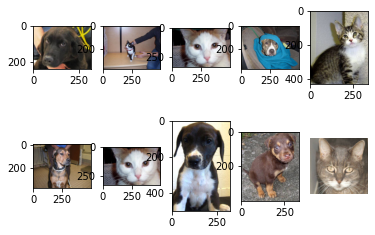

In [7]:
random_idx = np.random.randint(0, len(X_train) - 1, size=10)

fig = plt.figure()
for i, idx in enumerate(random_idx, start = 1):
    logging.info(f"{i} {X_train[idx]}")
    ax = fig.add_subplot(2,5,i)
    img = Image.open(X_train[idx])
    plt.imshow(img)

plt.axis('off')
plt.show()

### 4. Build Model<br>
<img src="https://i.imgur.com/ebkMGGu.jpg" width="100%"/>

* **Input Layer**: It represent input image data. It will reshape image into single dimension array. Example your image is 64x64 = 4096, it will convert to (4096,1) array.
* **Conv Layer**: This layer will extract features from image.
* **Pooling Layer**: This layer reduces the spatial volume of input image after convolution.
* **Fully Connected Layer**: It connect the network from a layer to another layer
* **Output Layer**: It is the predicted values layer. 

In [8]:
logging.info(f"train image shape: {train_data[0][0]}")


2023-01-24 21:20:29,887 | INFO : train image shape: tensor([[[0.0190, 0.0066, 0.0042,  ..., 0.0379, 0.0165, 0.0147],
         [0.0091, 0.0020, 0.0043,  ..., 0.0138, 0.0060, 0.0122],
         [0.0085, 0.0014, 0.0044,  ..., 0.0311, 0.0752, 0.0123],
         ...,
         [0.5718, 0.5667, 0.5593,  ..., 0.5753, 0.5962, 0.5714],
         [0.5575, 0.5603, 0.5584,  ..., 0.5715, 0.5897, 0.5832],
         [0.5647, 0.5667, 0.5647,  ..., 0.5756, 0.5754, 0.5908]],

        [[0.0582, 0.0395, 0.0279,  ..., 0.0614, 0.0400, 0.0382],
         [0.0413, 0.0310, 0.0277,  ..., 0.0236, 0.0134, 0.0356],
         [0.0323, 0.0244, 0.0256,  ..., 0.0481, 0.0936, 0.0310],
         ...,
         [0.3653, 0.3596, 0.3502,  ..., 0.5753, 0.5962, 0.5714],
         [0.3510, 0.3531, 0.3494,  ..., 0.5715, 0.5897, 0.5832],
         [0.3582, 0.3595, 0.3556,  ..., 0.5756, 0.5754, 0.5908]],

        [[0.1053, 0.0964, 0.1166,  ..., 0.1241, 0.1028, 0.1010],
         [0.0874, 0.0893, 0.1144,  ..., 0.0864, 0.0761, 0.0983],
      

In [9]:
model = Cnn().to(gpu.device)
model.train()

Cnn(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (re

In [10]:
optimizer = optim.Adam(params = model.parameters(),lr=hyper.lr)
criterion = nn.CrossEntropyLoss()

In [11]:
for epoch in range(hyper.epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    
    for data, label in train_loader:
        data = data.to(gpu.device)
        label = label.to(gpu.device)
        
        output = model(data)
        loss = criterion(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        acc = ((output.argmax(dim=1) == label).float().mean())
        epoch_accuracy += acc/len(train_loader)
        epoch_loss += loss/len(train_loader)
        
    print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))
    with torch.no_grad():
        epoch_val_accuracy=0
        epoch_val_loss =0
        for data, label in val_loader:
            data = data.to(gpu.device)
            label = label.to(gpu.device)
            
            val_output = model(data)
            val_loss = criterion(val_output,label)
            
            
            acc = ((val_output.argmax(dim=1) == label).float().mean())
            epoch_val_accuracy += acc/ len(val_loader)
            epoch_val_loss += val_loss/ len(val_loader)
            
        print(f'Epoch : {epoch+1}, val_accuracy : {epoch_val_accuracy}, val_loss : {epoch_val_loss}')

Epoch : 1, train accuracy : 0.560563862323761, train loss : 0.6839877367019653
Epoch : 1, val_accuracy : 0.6318946480751038, val_loss : 0.6534637808799744
Epoch : 2, train accuracy : 0.6019548773765564, train loss : 0.6581478118896484
Epoch : 2, val_accuracy : 0.5978947281837463, val_loss : 0.6477224826812744
Epoch : 3, train accuracy : 0.628383457660675, train loss : 0.6456336379051208
Epoch : 3, val_accuracy : 0.636526346206665, val_loss : 0.6438254117965698
Epoch : 4, train accuracy : 0.6307894587516785, train loss : 0.63942551612854
Epoch : 4, val_accuracy : 0.6074737310409546, val_loss : 0.6421108841896057
Epoch : 5, train accuracy : 0.6465789675712585, train loss : 0.6236649751663208
Epoch : 5, val_accuracy : 0.6585263013839722, val_loss : 0.615140438079834
Epoch : 6, train accuracy : 0.6550000309944153, train loss : 0.6220147609710693
Epoch : 6, val_accuracy : 0.6404210329055786, val_loss : 0.628939151763916
Epoch : 7, train accuracy : 0.6394736766815186, train loss : 0.62071818

In [14]:

# open a file where data need to be stored
filename = "cats_dogs_model"
save_pickle_object(model, filename)


2023-01-24 21:31:00,967 | INFO : Saving pickle file from: pickle\cats_dogs_model


In [15]:
# open a file where data need to be stored
filename = "cats_dogs_X_test"
save_pickle_object(X_test, filename)

2023-01-24 21:31:06,029 | INFO : Saving pickle file from: pickle\cats_dogs_X_test
